In [1]:
"""
OBJETIVO : Visualizar un dato de precipitacion en el mapa
NOTA: Solo se puede graficar los canales infrarojos (C07 +)
            
"""
Autor='Diego Paredes'

In [2]:
# Graficar imagenes
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf
import plotly.express as px

# Manejo de imagenes
import pandas as pd
import GOES
import numpy as np
from netCDF4 import Dataset, num2date

In [3]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [4]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/'          

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']

In [20]:
# Grafica la imagen satelital usando longitudes, latitudes, y los valores CMI. 
# Si se le entrega un punto (posLon,posLat), agregara un punto rojo
def dibujarMapa(lons,lats,field,mersh=0,point=[]):    
    if mersh:
        lons, lats = np.meshgrid(lons, lats)  
    else:
        field = field
    
    # Realiza el grafico  
    fig = plt.figure('ABI', figsize=(4,4), dpi=150)
    ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE)
    ax.add_feature(cf.BORDERS)
    img = ax.pcolormesh(lons, lats, field, cmap=plt.cm.Greys, transform=ccrs.PlateCarree())
    #img = ax.pcolormesh(lons, lats, field, vmin=200, vmax=300, transform=ccrs.PlateCarree())                
    plt.colorbar(img) 
    
    #if point:             
    #    plt.plot(lons[point[0]],lats[point[1]],'ro')        
        
    plt.show()       
    return 

In [21]:
#Como input (imagenFile) recibe un string que es el nombre del archivo de una imagen satelital (.nc),
# devuelve la matriz que representa esta imagen numpy.array(1200,950)
# Si imprimir = 1, va dibujar la imagen satelital
# En el parametro p, se puede inddicar un punto.
# P tiene 3 valores (punto + margen), el margen servirá para recortar la imagen antes de dibujar.
def getMapFile(imagenFile,mersh=0,imprimir=0,p=[]):
    try:
        ds = Dataset(imagenFile)      
    except:
        print("No se pudo leer los archivos de imagen")
        print(imagenFile)
        return -1,-1

    # convierte el formato de la variable de Int16 a Float32 y guarda el resultado
    field = ds.variables['CMI'][:].data.astype(np.int16)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    date = num2date(ds.variables['time'][:], ds.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    if p:
        margen = int(p[2])
    if imprimir:    
        dibujarMapa(lons,lats,field,mersh,point=p)
        if p:
            dibujarMapa(lons[p[0]-margen:p[0]+margen],
                        lats[p[1]-margen:p[1]+margen],
                        field[p[1]-margen:p[1]+margen,p[0]-margen:p[0]+margen],mersh,point=[])
        
    # Solo devuele la parte cortada        
    return lons[p[0]-margen:p[0]+margen],lats[p[1]-margen:p[1]+margen],field[p[1]-margen:p[1]+margen,p[0]-margen:p[0]+margen]          

In [22]:
# Se le indica la fecha, las cordenadas (point,margen), el canal (C13,C07,C08) y el tiempo (min 00,10,20,30,40,50) a dibujar
def visualizarDato(fecha, point=[], canal='C13', tiempo='00', imprimir=1):    
    year, month, day, hour = fecha.split('-')    
    # Encontramos el file
    if year=='2020':
        fileImagen = f'D:/GOES/{canal}/{year}/{month}/G16_{canal}_Cyl_{year}{month}{day}-{hour}{tiempo}.nc'
    else:
        fileImagen = f'F:/GOES/{canal}/{year}/{month}/G16_{canal}_Cyl_{year}{month}{day}-{hour}{tiempo}.nc'
        
    l,t,f = getMapFile(fileImagen,imprimir=imprimir,p=point)    
    return l,t,f

In [23]:
#fileDataset = f'{path_base}/Archivos/Inicial/dsCompletoPP_V2.csv'        
#df = pd.read_csv(fileDataset)
#df.head(2)

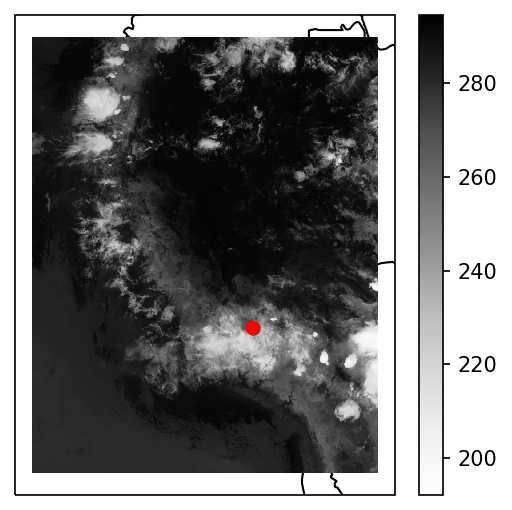

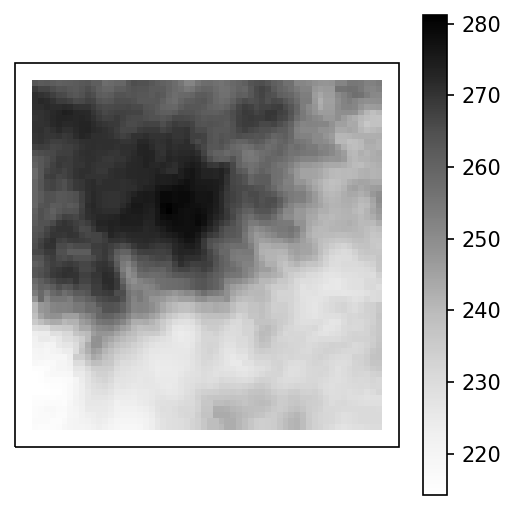

281.23

In [24]:
# Dato de 0 mm/h
xlon,ylat = 607,799# 269,497
fecha = '2020-12-10-03'
margen= 30

_,_,field1 = visualizarDato(fecha, point=[xlon,ylat,margen], canal='C13', tiempo='00',imprimir=1)
field1.max()

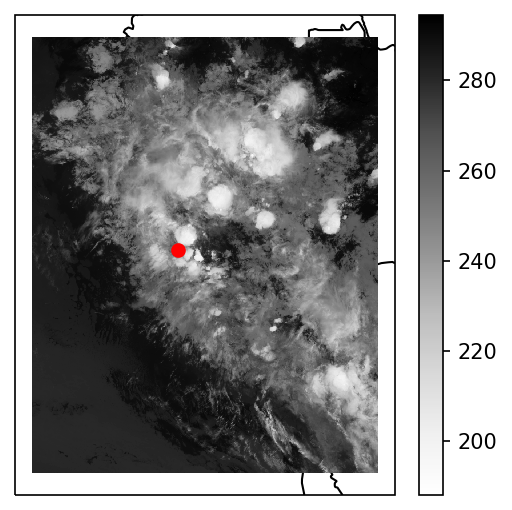

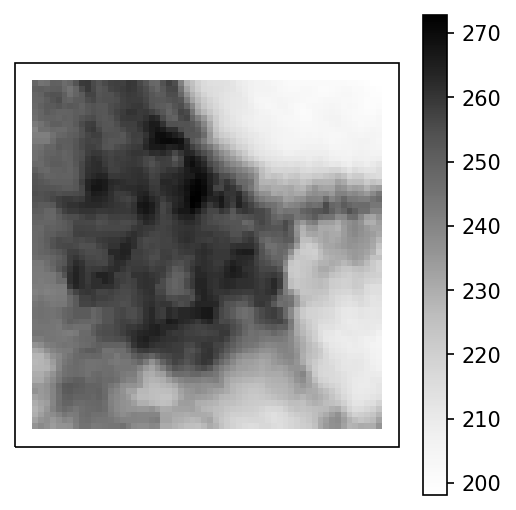

272.87

In [25]:
# Dato de 20 mm/h
xlon,ylat = 400,586
margen= 30 

_,_,field10 = visualizarDato('2020-12-05-04', point=[xlon,ylat,margen], canal='C13', tiempo='00',imprimir=1)
field10.max()

In [12]:
def plotMapPrecip(df, size='PRECIPITACION'):
    
    
    """
    Datos de estaciones
    """
    stat_path = f'{path_base}/Archivos/Inicial/estaciones.csv'
    dfSt = pd.read_csv(stat_path)
    dfSt.columns = ['-','CODIGO','ESTACION','LON','LAT','ALT']
    dfSt = dfSt.set_index('CODIGO')
    
    """
    Unirmos los datos con los de precipitaciones
    """
    df2 = pd.concat([dfSt, df], axis=1)
    df2 = df2[['LON','LAT','ALT','PRECIPITACION']]
    df2.dropna(axis=0, inplace=True, how='any')
    
    
    """
    Graficamos
    """
    if size:
        fig = px.scatter_mapbox(df2, lat="LAT", lon="LON", hover_data=["ALT"],
                        size = 'PRECIPITACION',
                        zoom=5, height=800)
    else:
        fig = px.scatter_mapbox(df2, lat="LAT", lon="LON", hover_data=["ALT"],
                       
                        zoom=5, height=800)
        
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

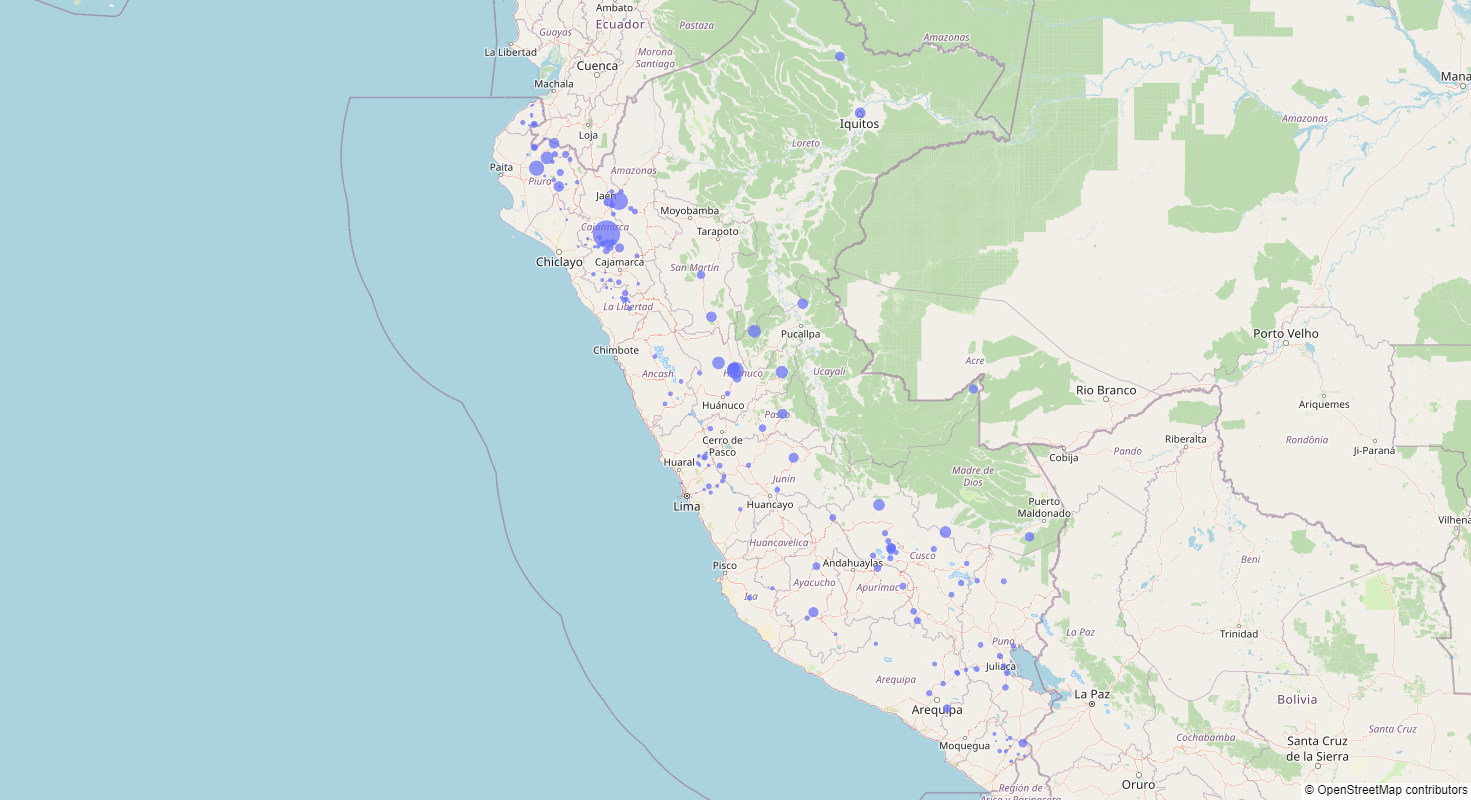

In [ ]:
arch_path = f'{path_base}/Archivos/Dataset/dsFLAGV2.csv'
dfPret = pd.read_csv(arch_path)
dfComp = dfPret[(dfPret['FLAG'].isin(['C0000002','M0000002'])) & (dfPret['FLAGV2'].isin(['D01','D02']))]
dfComp['CODIGO'] = 'X' + dfComp['CODIGO']
dfComp = dfComp.groupby(['CODIGO']).mean('PRECIPITACION')
#dfComp
plotMapPrecip(dfComp)

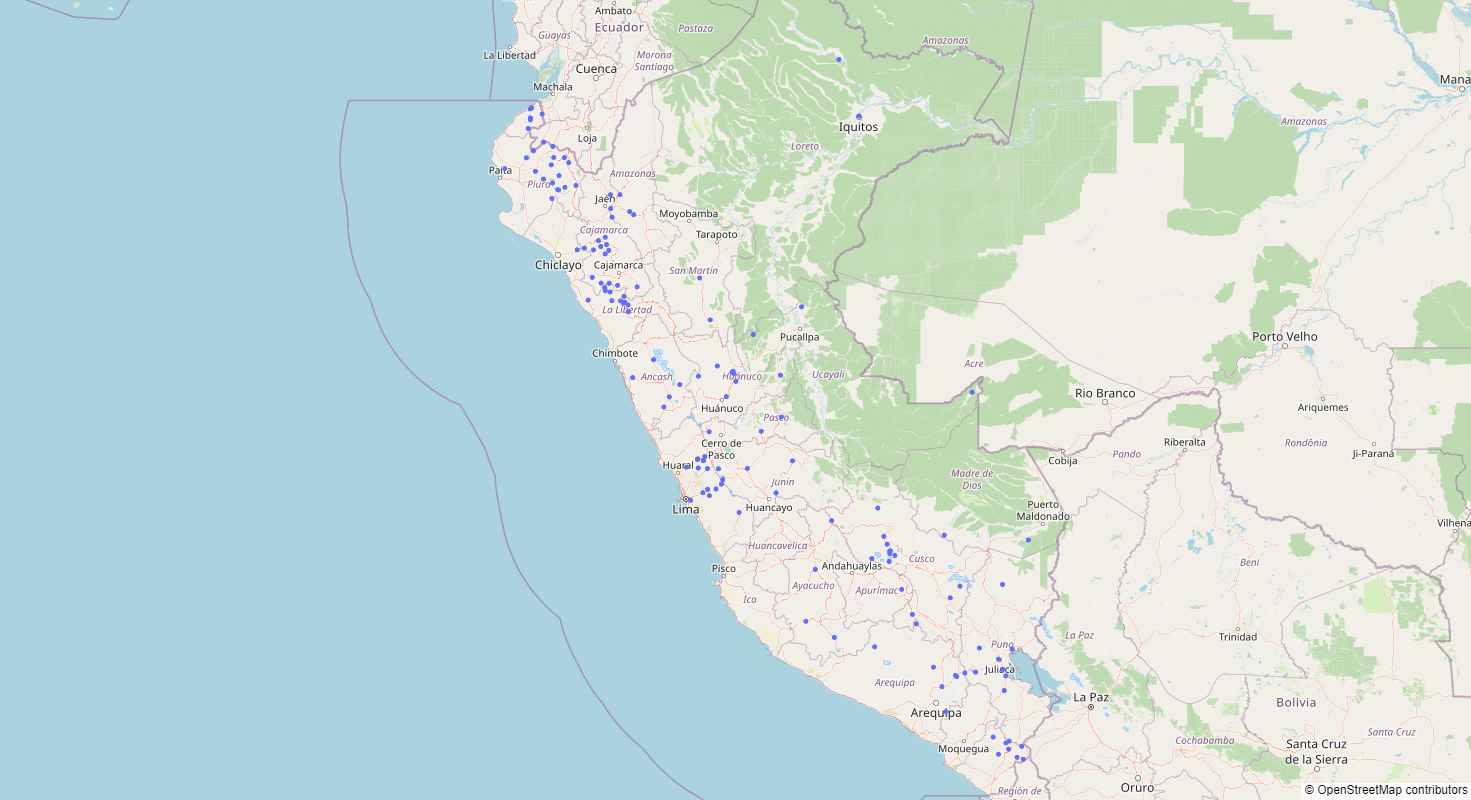

In [ ]:
arch_path = f'{path_base}/Archivos/Dataset/Clasificacion/Entrenamiento/SplitConDA_20C_DM_V2/CLASE_TrainDS_1.csv'
dfTrain = pd.read_csv(arch_path)
dfCompTrain = dfTrain[(dfTrain['flag'].isin(['C0000002','M0000002']))]
dfCompTrain['CODIGO'] = 'X' + dfCompTrain['codigo']
dfCompTrain = dfCompTrain[['dato','CODIGO']]
dfCompTrain.columns = ['PRECIPITACION','CODIGO']
dfCompTrain = dfCompTrain.groupby(['CODIGO']).mean('PRECIPITACION')
plotMapPrecip(dfCompTrain, size=None)

In [ ]:
len(dfVal)

NameError: name 'dfVal' is not defined

In [ ]:
arch_path = f'{path_base}/Archivos/Dataset/Clasificacion/Validacion/ClaseV2_DUD_ValidacionDS.csv'
dfVal = pd.read_csv(arch_path)
dfCompVal = dfVal[(dfVal['flag'].isin(['C0000002','M0000002']))]
dfCompVal['CODIGO'] = 'X' + dfCompVal['codigo']
dfCompVal = dfCompVal[['dato','CODIGO']]
dfCompVal.columns = ['PRECIPITACION','CODIGO']
dfCompVal = dfCompVal.groupby(['CODIGO']).mean('PRECIPITACION')
plotMapPrecip(dfCompVal, size=None)